In [96]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Layer
from keras.layers import Input, Dense, Activation, LeakyReLU, Permute, Bidirectional, CuDNNLSTM
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
import tensorflow as tf
import tensorflow as tf
from primus import CTC_PriMuS
import ctc_utils
import os
import tensorflow as tf
from primus import CTC_PriMuS
import ctc_utils
import os
import cv2

In [97]:
tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [98]:
def default_model_params(img_height, vocabulary_size):
    params = dict()
    params['img_height'] = img_height
    params['img_width'] = None
    params['batch_size'] = 128
    params['img_channels'] = 1
    params['conv_blocks'] = 4
    params['conv_filter_n'] = [32, 64, 128, 256]
    params['conv_filter_size'] = [ [3,3], [3,3], [3,3], [3,3] ]
    params['conv_pooling_size'] = [ [2,2], [2,2], [2,2], [2,2] ]
    params['rnn_units'] = 128
    params['rnn_layers'] = 2
    params['vocabulary_size'] = vocabulary_size
    return params

In [99]:
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost
        # self.loss_fn = K.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64") # 16
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        print("Y_pred shape:  ",y_pred.shape)
        print("Y_true shape:  ",y_true.shape)
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [100]:

def ctc_crnn(params,width_rem = 128):
    input_shape = (params['img_height'],params['img_width'], params['img_channels'])

    inputs = Input(name='image', shape=input_shape, dtype='float32')

    labels = Input(name="label", shape=(None,), dtype="float32")

    width_reduction = 1
    height_reduction = 1

    #conv2d layer
    for i in range(params['conv_blocks']):
            inner = Conv2D(params['conv_filter_n'][i], params['conv_filter_size'][i], padding='same', name='conv'+ str(i+1), kernel_initializer='he_normal')(inputs if i == 0 else inner)
            inner = BatchNormalization()(inner)
            inner = LeakyReLU(0.2)(inner)
            inner = MaxPooling2D(pool_size=params['conv_pooling_size'][i], strides = params['conv_pooling_size'][i], name='max' + str(i+1))(inner)

            width_reduction = width_reduction * params['conv_pooling_size'][i][1]
            height_reduction = height_reduction * params['conv_pooling_size'][i][0]
            print(width_reduction)
    
    print(width_reduction)
    features = K.permute_dimensions(inner, (2,0,3,1))
    feature_dim = params['conv_filter_n'][-1] * (params['img_height'] / height_reduction)
    feature_width = width_rem / width_reduction
    print("Feature width:",feature_width)
    features = tf.reshape(features, tf.stack([tf.cast(feature_width,'int32'), 16, tf.cast(feature_dim,'int32')]))
    
    # RNN block
    lstm_1 = CuDNNLSTM(params['rnn_units'], return_sequences=True, kernel_initializer='he_normal', name='lstm1')(features)  # (None, 32, 512)
    lstm_1b = CuDNNLSTM(params['rnn_units'], return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(features)
    reversed_lstm_1b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)

    lstm1_merged = add([lstm_1, reversed_lstm_1b])  # (None, 32, 512)
    lstm1_merged = BatchNormalization()(lstm1_merged)
    
    lstm_2 = CuDNNLSTM(params['rnn_units'], return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = CuDNNLSTM(params['rnn_units'], return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    reversed_lstm_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_2b)

    lstm2_merged = concatenate([lstm_2, reversed_lstm_2b])  # (None, 32, 1024)
    lstm2_merged = BatchNormalization()(lstm2_merged)

    # transforms RNN output to character activations:
    num_classes = params['vocabulary_size'] + 1
    inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(lstm2_merged) #(None, 32, 63)
    y_pred = Activation('softmax', name='softmax')(inner)

    output = CTCLayer(name="ctc_loss")(labels, y_pred)


    return Model(inputs=[inputs, labels], outputs=output)

In [101]:
corpus_dirpath = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/primusCalvoRizoAppliedSciences2018/"
corpus_filepath = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/train.txt"
dictionary_path = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/vocabulary_semantic.txt"
primus = CTC_PriMuS(corpus_dirpath,corpus_filepath,dictionary_path, True, val_split = 0.1)

Training with 9000 and validating with 1000


In [102]:
# Get Data
image_paths = []
image_texts = []

class PriMuS_Data:
    def __init__(self, corpus_dirpath, corpus_filepath, dictionary_path):
        self.corpus_dirpath = corpus_dirpath

        # Corpus
        corpus_file = open(corpus_filepath,'r')
        self.corpus_list = corpus_file.read().splitlines()
        corpus_file.close()

        self.current_idx = 0

        # Dictionary
        self.word2int = {}
        self.int2word = {}
            
        dict_file = open(dictionary_path,'r')
        dict_list = dict_file.read().splitlines()
        for word in dict_list:
            if not word in self.word2int:
                word_idx = len(self.word2int)
                self.word2int[word] = word_idx
                self.int2word[word_idx] = word

        dict_file.close()

        self.vocabulary_size = len(self.word2int)
    
    def get_vocabulary_size(self):
        return self.vocabulary_size
        
    def get_data(self):
        return self.corpus_list
    
    def trim_ds(self):
        val_split = 0.9
        folder_path = self.corpus_dirpath
        list_of_files = self.corpus_list #10,000 filenames

        image_paths = [self.corpus_dirpath+f"{x}/{x}.png" for x in self.corpus_list] # list of image paths
        text_paths = [self.corpus_dirpath+f"{x}/{x}.semantic" for x in self.corpus_list]

        image_texts = [] # list of strings

        for path in text_paths:
            with open(path, "r") as file:
                image_texts.append(file.readline())
        

        # TODO: do line 17 from the link : https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

        # TODO: Use self.word2int to encode each element of the lists in image_texts
        # Input image_texts = [  ['clef','C-note'] , [.......], ....]
        # Final image_texts = [  [5,3] , [.......], ....]
        # if 'clef' == 5, 'C-note' == 3 in word2int dictionary
        # Also add padding using the function below so length of each element is consistent

        # from tensorflow.keras.preprocessing.sequence import pad_sequences

        # def encode_to_labels(txt):
        #     # encoding each output word into digits
        #     dig_lst = []
        #     for index, char in enumerate(txt):
        #         try:
        #             dig_lst.append(char_list.index(char))
        #         except:
        #             print(char)
        #     return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

        # padded_image_texts = list(map(encode_to_labels, image_texts))
        # padded_image_texts[0]


        train_image_paths = image_paths[ : int(len(image_paths) * val_split)]
        train_image_texts = image_texts[ : int(len(image_texts) * val_split)]

        val_image_paths = image_paths[int(len(image_paths) * val_split) : ]
        val_image_texts = image_texts[int(len(image_texts) * val_split) : ]

        return {"train":{"images":train_image_paths, "text": train_image_texts}, "val":{"images":val_image_paths, "text": val_image_texts}}



In [110]:
# TODO: do line 17 from the link : https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

In [103]:
data_obj = PriMuS_Data(corpus_dirpath, corpus_filepath, dictionary_path)
lst = data_obj.trim_ds()

In [104]:
print(data_obj.vocabulary_size)

1781


In [105]:
# Resize images to desired dimensions with unknown width
def resize_no_width(image, height):
    width = int(float(height * image.shape[1]) / image.shape[0])
    sample_img = cv2.resize(image, (width, height))
    return sample_img


# Pre-process a single image sample(resize/normalize/max_width resize)
def process_single_sample(img_path, label,max_width = 30):
    params = default_model_params(img_height,primus.vocabulary_size)
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img,[params['img_height'], max_width])
    # TODO: Get height from params, calculate width from max of all images
    return {"image": img, "label": label}


In [106]:
batch_size = 32


image_widths = [cv2.imread(img).shape[1] for img in lst["train"]["images"]]
max_image_width = max(image_widths)
print(max_image_width)


# Pre-process a single image sample(resize/normalize/max_width resize)
def process_single_sample(img_path, label):
    params = default_model_params(img_height,primus.vocabulary_size)
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img,[params['img_height'], max_image_width])
    # TODO: Get height from params, calculate width from max of all images
    return {"image": img, "label": label}
# train_dataset = train_dataset.map(process_single_sample(max_width = max_image_width))

# processed_images = [process_single_sample(img,label,max_image_width) for img,label in zip(lst["train"]["images"], lst["train"]["text"])]

train_dataset = tf.data.Dataset.from_tensor_slices((lst['train']['images'], lst['train']['text']))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((lst['train']['images'], lst['train']['text']))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

2003


In [107]:
# Parameterization
img_height = 128
params = default_model_params(img_height,primus.vocabulary_size)
max_epochs = 100
dropout = 0.5
# Model
model = ctc_crnn(params, width_rem= max_image_width)
model.summary()

2
4
8
16
16
Feature width: 125.1875
Y_pred shape:   (125, 16, 1782)
Y_true shape:   (None, None)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, None,   0           []                               
                                1)]                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 128, None, 3  320         ['image[0][0]']                  
                                2)                                                                
                                                                                                  
 batch_normalization_42 (BatchN  (None, 128, None, 3  128        ['conv1[0][0]']              

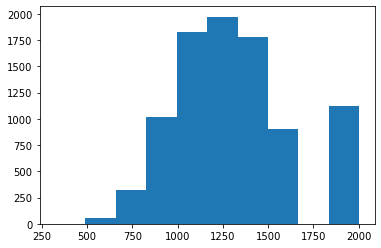

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.Series(image_widths)
plt.hist(df)
plt.show()

https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

In [109]:
# Compile

optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(optimizer = optimizer)

# checkpoint = ModelCheckpoint(filepath=file_path, 
#                                 monitor='val_loss', 
#                                 verbose=1, 
#                                 save_best_only=True, 
#                                 mode='min')

#     callbacks_list = [checkpoint, 
#                       WandbCallback(monitor="val_loss", 
#                                     mode="min", 
#                                     log_weights=True),
#                       PlotPredictions(frequency=1),
#                       EarlyStopping(patience=3, verbose=1)]

history = model.fit(train_dataset, 
                    epochs = max_epochs,
                    validation_data=validation_dataset,
                    verbose = 1,
                    # callbacks = callbacks_list,
                    shuffle=True)

c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100


ValueError: in user code:

    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "ctc_loss" (type CTCLayer).
    
    in user code:
    
        File "C:\Users\steli\AppData\Local\Temp\ipykernel_8712\538555551.py", line 13, in call  *
            label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
        ValueError: slice index 1 of dimension 0 out of bounds. for '{{node model_7/ctc_loss/strided_slice_2}} = StridedSlice[Index=DT_INT32, T=DT_INT32, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](model_7/ctc_loss/Shape_2, model_7/ctc_loss/strided_slice_2/stack, model_7/ctc_loss/strided_slice_2/stack_1, model_7/ctc_loss/strided_slice_2/stack_2)' with input shapes: [1], [1], [1], [1] and with computed input tensors: input[1] = <1>, input[2] = <2>, input[3] = <1>.
    
    
    Call arguments received:
      • y_true=tf.Tensor(shape=(None,), dtype=float32)
      • y_pred=tf.Tensor(shape=(125, 16, 1782), dtype=float32)
